# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 100000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 3000
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD_90'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Submean()
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      Pad(padding=4, fill=0, padding_mode=constant)
      RandomResizedCrop(size=[32, 32], scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomHorizontalFlip(p=0.5)
) 256
valid.transforms = ToTensor() 256
test.transforms = ToTensor() 256


## Confirm that the dataset is loaded properly

In [6]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([0.5010, 0.4888, 0.4485])
Shape of y: torch.Size([256]) torch.int64


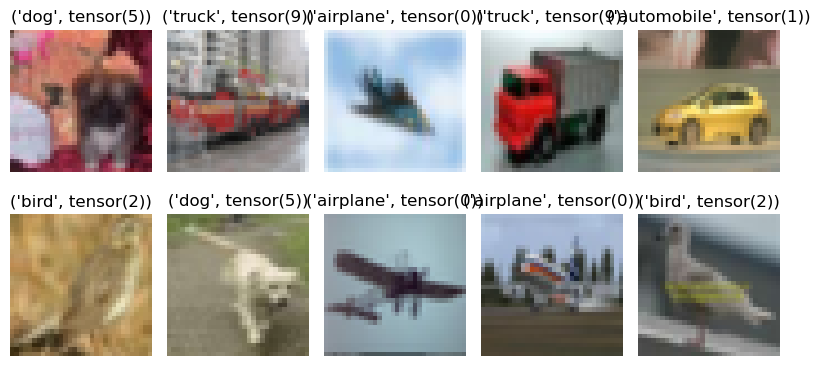

In [7]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [10]:
model.named_modules

<bound method Module.named_modules of MyResNet_CIFAR(
  (single_conv32block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv32blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv

In [11]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 0.464M                 | 18.018G    |
|  single_conv32block            |  0.464K                |  0.134G    |
|   single_conv32block.0         |   0.432K               |   0.113G   |
|    single_conv32block.0.weight |    (16, 3, 3, 3)       |            |
|   single_conv32block.1         |   32                   |   20.972M  |
|    single_conv32block.1.weight |    (16,)               |            |
|    single_conv32block.1.bias   |    (16,)               |            |
|  conv32blocks                  |  23.36K                |  6.25G     |
|   conv32blocks.0               |   4.672K               |   1.25G    |
|    conv32blocks.0.conv1        |    2.304K              |    0.604G  |
|    conv32blocks.0.bn1          |    32                  |    20.972M |
|    conv32blocks.0.conv2        |    2.304K       

# Define Training

## (1) Define Criterion

In [12]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [13]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience, model, file_path):
        self.best_eval_loss = float("inf")
        self.early_stop_counter = 0
        self.PATIENCE = patience
        self.file_path = file_path
        self.model = model
        pass

    def check(self, eval_loss):
        if eval_loss < self.best_eval_loss:
            self.best_eval_loss = eval_loss
            self.early_stop_counter = 0
            print("updated best eval loss :", self.best_eval_loss)
            torch.save(self.model.state_dict(), "models/" + self.file_path + ".pth")
            return False
        else:
            self.early_stop_counter += 1
            if self.early_stop_counter >= self.PATIENCE:
                print(f"Early stop!! best_eval_loss = {self.best_eval_loss}")
                return True
                
    def state_dict(self):
        return {"best_eval_loss": self.best_eval_loss, "early_stop_counter": self.early_stop_counter}
    
    def load_state_dict(self, state_dict):
        self.best_eval_loss = state_dict["best_eval_loss"]
        self.early_stop_counter = state_dict["early_stop_counter"]
        
        return
    
earlystopper = EarlyStopper(EARLYSTOPPINGPATIENCE, model, file_path)

## (4) Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR10": 1000, "CIFAR100": 1000, "ImageNet2012": 30}

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=100
)

## (5) Define AMP scaler

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [18]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100000] :


100%|██████████| 176/176 [00:09<00:00, 18.86it/s]

Train Loss: 0.0130 | Train Acc: 12.00%


Valid Loss: 2.2929 | Valid Acc: 12.18%
Test  Loss: 2.3050 | Test Acc: 10.02%
updated best eval loss : 2.2929266810417177
--------------------------------------------------
[Epoch 2/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.72it/s]


Train Loss: 0.0130 | Train Acc: 13.50%
Valid Loss: 2.2947 | Valid Acc: 13.22%
Test  Loss: 2.3170 | Test Acc: 9.99%
--------------------------------------------------
[Epoch 3/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.13it/s]


Train Loss: 0.0129 | Train Acc: 12.50%
Valid Loss: 2.2582 | Valid Acc: 13.62%
Test  Loss: 2.3008 | Test Acc: 10.30%
updated best eval loss : 2.258205831050873
--------------------------------------------------
[Epoch 4/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.14it/s]


Train Loss: 0.0126 | Train Acc: 13.50%
Valid Loss: 2.2094 | Valid Acc: 16.06%
Test  Loss: 2.1369 | Test Acc: 18.45%
updated best eval loss : 2.2094252943992614
--------------------------------------------------
[Epoch 5/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.96it/s]


Train Loss: 0.0118 | Train Acc: 21.50%
Valid Loss: 2.0933 | Valid Acc: 20.82%
Test  Loss: 1.9015 | Test Acc: 26.90%
updated best eval loss : 2.0932904958724974
--------------------------------------------------
[Epoch 6/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.89it/s]


Train Loss: 0.0119 | Train Acc: 26.00%
Valid Loss: 2.0341 | Valid Acc: 23.48%
Test  Loss: 1.8191 | Test Acc: 31.06%
updated best eval loss : 2.034073883295059
--------------------------------------------------
[Epoch 7/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.91it/s]


Train Loss: 0.0110 | Train Acc: 27.50%
Valid Loss: 1.9707 | Valid Acc: 28.06%
Test  Loss: 1.7083 | Test Acc: 36.52%
updated best eval loss : 1.970718103647232
--------------------------------------------------
[Epoch 8/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.65it/s]


Train Loss: 0.0105 | Train Acc: 33.50%
Valid Loss: 2.0816 | Valid Acc: 26.70%
Test  Loss: 1.7407 | Test Acc: 36.28%
--------------------------------------------------
[Epoch 9/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.88it/s]


Train Loss: 0.0100 | Train Acc: 34.50%
Valid Loss: 1.8053 | Valid Acc: 35.86%
Test  Loss: 1.6256 | Test Acc: 42.46%
updated best eval loss : 1.805321842432022
--------------------------------------------------
[Epoch 10/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.08it/s]


Train Loss: 0.0099 | Train Acc: 39.00%
Valid Loss: 1.7811 | Valid Acc: 35.40%
Test  Loss: 1.5075 | Test Acc: 45.26%
updated best eval loss : 1.7810763657093047
--------------------------------------------------
[Epoch 11/100000] :


 79%|███████▉  | 139/176 [00:07<00:01, 18.78it/s]

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))